In [1]:
import pandas as pd
import sidetable
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
from pandas.tseries.offsets import BDay
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')
pd.options.display.max_rows = 11

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
one_path = "\\Users\\User\\OneDrive\\Documents\\Data\\"
osd_path = "\\Users\\User\\OneDrive\\Documents\\obsidian-git-sync\\Data\\"

today = date.today()
today

datetime.date(2023, 7, 15)

In [2]:
num_business_days = BDay(1)
yesterday = today - num_business_days
yesterday = yesterday.date()
today, yesterday

(datetime.date(2023, 7, 15), datetime.date(2023, 7, 14))

### Restart and Run All Cells

In [3]:
sqlUpd = """
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)"""
rp = const.execute(sqlUpd)
rp.rowcount

30

In [4]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()

In [5]:
format_dict = {
    'shares':'{:,}','div_rnk':'{:,}','amt_rnk':'{:,}',  
    'price':'฿{:.2f}','unit_cost':'฿{:.2f}','mkt_price':'฿{:.2f}',
    'cost_amt':'฿{:,.2f}','div_amt':'฿{:,.2f}','mkt_amt':'฿{:,.2f}',
    'cumulative_mkt_amt':'฿{:,.2f}','profit':'฿{:,.2f}','base_amt':'฿{:,.2f}',
    'cumsum':'฿{:,.2f}','dividend':'฿{:.4f}','cumulative_cost_amt':'฿{:,.2f}',    
    'pct':'{:,.2f}%','cost_pct':'{:,.2f}%','mkt_pct':'{:,.2f}%',
    'pft_pct':'{:,.2f}%','percent':'{:,.2f}%','cumulative_percent':'{:,.2f}%',
}

### Discrepancies calculation

In [6]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df.drop(['volsell', 'volbal'], axis=1, inplace=True)
df.rename(columns={'volbuy': 'shares','price':'unit_cost'}, inplace=True)
df['shares'] = df['shares'].astype('int64')
df['cost_amt'] = df.shares * df.unit_cost
df.shape

(30, 9)

In [7]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(251, 2)

In [8]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [9]:
my_stocks["base_amt"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict)

,name,market,base_amt
0,ACE,SET100 / SETTHSI,"฿300,000.00"
1,ADVANC,SET50 / SETHD / SETTHSI,"฿450,000.00"
2,AEONTS,SET,"฿150,000.00"
3,AH,sSET / SETTHSI,"฿150,000.00"
4,AIE,sSET,"฿150,000.00"


In [10]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(30, 11)

In [11]:
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base_amt*100,2)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
1,SINGER,4,"6,000",฿24.80,"฿148,800.00","฿300,000.00",49.60%
2,PTG,4,"3,600",฿11.40,"฿41,040.00","฿300,000.00",13.68%
3,KCE,4,"10,000",฿77.25,"฿772,500.00","฿300,000.00",257.50%
4,MCS,1,"78,000",฿15.10,"฿1,177,800.00","฿150,000.00",785.20%
6,TMT,1,"36,000",฿10.20,"฿367,200.00","฿150,000.00",244.80%


In [12]:
df_merge[mask].nlargest(5, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
4,MCS,1,"78,000",฿15.10,"฿1,177,800.00","฿150,000.00",785.20%
10,SENA,1,"105,000",฿4.48,"฿470,400.00","฿150,000.00",313.60%
25,SYNEX,4,"15,000",฿28.70,"฿430,500.00","฿150,000.00",287.00%
3,KCE,4,"10,000",฿77.25,"฿772,500.00","฿300,000.00",257.50%
6,TMT,1,"36,000",฿10.20,"฿367,200.00","฿150,000.00",244.80%


In [13]:
df_merge[mask].nsmallest(5, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
24,AWC,4,"9,000",฿4.96,"฿44,640.00","฿450,000.00",9.92%
2,PTG,4,"3,600",฿11.40,"฿41,040.00","฿300,000.00",13.68%
19,BBL,3,400,฿155.00,"฿62,000.00","฿450,000.00",13.78%
28,ICHI,4,"1,500",฿14.30,"฿21,450.00","฿150,000.00",14.30%
18,AH,4,"1,200",฿37.00,"฿44,400.00","฿150,000.00",29.60%


In [14]:
df_merge.stb.freq(["period"], value="cost_amt").style.format(format_dict)

,period,cost_amt,percent,cumulative_cost_amt,cumulative_percent
0,2,"฿5,483,900.00",47.53%,"฿5,483,900.00",47.53%
1,1,"฿2,403,900.00",20.83%,"฿7,887,800.00",68.36%
2,4,"฿2,116,830.00",18.35%,"฿10,004,630.00",86.71%
3,3,"฿1,533,500.00",13.29%,"฿11,538,130.00",100.00%


### Rank

In [15]:
sql = '''
SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1
ORDER BY period, name'''
sql = sql % yesterday 
print(sql)


SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "2023-07-14"
AND active = 1
ORDER BY period, name


In [16]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()
colt = 'name shares unit_cost cost_amt mkt_price mkt_amt amt_rnk mkt_pct div_rnk div_amt'.split()
colu = 'name shares unit_cost cost_amt mkt_price mkt_amt dividend div_amt mkt_pct div_rnk amt_rnk period'.split()

In [17]:
df = pd.read_sql(sql, const)
df.rename(columns={'volbuy': 'shares'}, inplace=True)
df['shares'] = df.shares.astype(int)
df['cost_amt'] = round(df['shares'] * df['unit_cost'], 2)
df['mkt_amt'] = round(df['shares'] * df['mkt_price'], 2)
df['div_amt'] = round(df['shares'] * df['dividend'], 2)
df['cost_pct'] = round(df['div_amt'] / df['cost_amt'] * 100,2)
df['mkt_pct'] = round(df['div_amt'] / df['mkt_amt'] * 100,2)
df['pft_pct'] = round((df['mkt_amt'] - df['cost_amt']) / df['cost_amt'] * 100,2)
df['div_rnk'] = df.mkt_pct.rank(ascending=False)
df['amt_rnk'] = df.mkt_amt.rank(ascending=False)
df[colu].sort_values(['div_rnk'],ascending=[True]).head(15).style.format(format_dict)

,name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,dividend,div_amt,mkt_pct,div_rnk,amt_rnk,period
10,RCL,"27,000",฿38.75,"฿1,046,250.00",฿24.20,"฿653,400.00",฿7.0000,"฿189,000.00",28.93%,1.0,3.0,2
8,JASIF,"130,000",฿10.00,"฿1,300,000.00",฿6.95,"฿903,500.00",฿0.9200,"฿119,600.00",13.24%,2.0,1.0,2
11,STA,"5,000",฿40.00,"฿200,000.00",฿17.00,"฿85,000.00",฿2.0000,"฿10,000.00",11.76%,3.0,22.0,2
6,DIF,"30,000",฿14.70,"฿441,000.00",฿10.70,"฿321,000.00",฿1.0185,"฿30,555.00",9.52%,4.0,8.5,2
7,GVREIT,"30,000",฿8.90,"฿267,000.00",฿8.40,"฿252,000.00",฿0.7816,"฿23,448.00",9.30%,5.0,14.0,2
13,WHAIR,"50,000",฿8.70,"฿435,000.00",฿7.05,"฿352,500.00",฿0.6037,"฿30,185.00",8.56%,6.0,7.0,2
9,NER,"27,000",฿7.45,"฿201,150.00",฿4.56,"฿123,120.00",฿0.3800,"฿10,260.00",8.33%,7.0,20.0,2
5,CPNREIT,"60,000",฿17.55,"฿1,053,000.00",฿10.90,"฿654,000.00",฿0.8877,"฿53,262.00",8.14%,8.0,2.0,2
4,ASP,"30,000",฿3.80,"฿114,000.00",฿2.78,"฿83,400.00",฿0.2000,"฿6,000.00",7.19%,9.0,23.0,2
14,WHART,"30,000",฿11.70,"฿351,000.00",฿10.70,"฿321,000.00",฿0.7653,"฿22,959.00",7.15%,10.0,8.5,2


In [18]:
df1 = df[df['period'] == '1'].copy()
df1['div_rnk'] = df1.mkt_pct.rank(ascending=False)
df1['amt_rnk'] = df1.mkt_amt.rank(ascending=False)
df1_out = df1[colt].sort_values('div_rnk')
df1_tab = pn.widgets.Tabulator(df1_out, layout='fit_data', width=950)
df1_tab.style.format(format_dict)

,name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,amt_rnk,mkt_pct,div_rnk,div_amt
2,SENA,"105,000",฿4.48,"฿470,400.00",฿3.00,"฿315,000.00",2.0,6.84%,1.0,"฿21,556.50"
3,TMT,"36,000",฿10.20,"฿367,200.00",฿7.30,"฿262,800.00",3.0,4.11%,2.0,"฿10,800.00"
0,MCS,"78,000",฿15.10,"฿1,177,800.00",฿6.35,"฿495,300.00",1.0,3.15%,3.0,"฿15,600.00"
1,PTTGC,"6,000",฿64.75,"฿388,500.00",฿40.50,"฿243,000.00",4.0,2.47%,4.0,"฿6,000.00"


In [19]:
dividend = df1_out['div_amt'].sum()
market_amt = df1_out['mkt_amt'].sum()
percent = (dividend / market_amt) * 100

In [20]:
dividend, market_amt, percent

(53956.5, 1316100.0, 4.099726464554365)

In [21]:
array = pd.Series([dividend, market_amt])
array = array.map('฿{:,.2f}'.format)
for value in array:
    print(f"The value is: {value}")

The value is: ฿53,956.50
The value is: ฿1,316,100.00


In [22]:
df2 = df[df['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.mkt_amt.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=950)
df2_tab.style.format(format_dict)

,name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,amt_rnk,mkt_pct,div_rnk,div_amt
10,RCL,"27,000",฿38.75,"฿1,046,250.00",฿24.20,"฿653,400.00",3.0,28.93%,1.0,"฿189,000.00"
8,JASIF,"130,000",฿10.00,"฿1,300,000.00",฿6.95,"฿903,500.00",1.0,13.24%,2.0,"฿119,600.00"
11,STA,"5,000",฿40.00,"฿200,000.00",฿17.00,"฿85,000.00",9.0,11.76%,3.0,"฿10,000.00"
6,DIF,"30,000",฿14.70,"฿441,000.00",฿10.70,"฿321,000.00",5.5,9.52%,4.0,"฿30,555.00"
7,GVREIT,"30,000",฿8.90,"฿267,000.00",฿8.40,"฿252,000.00",7.0,9.30%,5.0,"฿23,448.00"
13,WHAIR,"50,000",฿8.70,"฿435,000.00",฿7.05,"฿352,500.00",4.0,8.56%,6.0,"฿30,185.00"
9,NER,"27,000",฿7.45,"฿201,150.00",฿4.56,"฿123,120.00",8.0,8.33%,7.0,"฿10,260.00"
5,CPNREIT,"60,000",฿17.55,"฿1,053,000.00",฿10.90,"฿654,000.00",2.0,8.14%,8.0,"฿53,262.00"
4,ASP,"30,000",฿3.80,"฿114,000.00",฿2.78,"฿83,400.00",10.0,7.19%,9.0,"฿6,000.00"
14,WHART,"30,000",฿11.70,"฿351,000.00",฿10.70,"฿321,000.00",5.5,7.15%,10.0,"฿22,959.00"


In [23]:
file_name = 'dividend-050.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
one_file = one_path + file_name
osd_file = osd_path + file_name

df2_out[colt].to_csv(output_file, header=True, index=False)
df2_out[colt].to_csv(data_file, header=True, index=False)
df2_out[colt].to_csv(one_file, header=True, index=False)
df2_out[colt].to_csv(osd_file, header=True, index=False)

In [24]:
df2_out['div_amt'].sum()

499256.0

In [25]:
file_name = 'rank-div-market.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
one_file = one_path + file_name

df2.sort_values(['div_rnk'],ascending=[True]).to_csv(output_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(data_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(one_file, index=False)

In [26]:
df.stb.freq(["period"], value="cost_amt").style.format(format_dict)

,period,cost_amt,percent,cumulative_cost_amt,cumulative_percent
0,2,"฿5,483,900.00",47.53%,"฿5,483,900.00",47.53%
1,1,"฿2,403,900.00",20.83%,"฿7,887,800.00",68.36%
2,4,"฿2,116,830.00",18.35%,"฿10,004,630.00",86.71%
3,3,"฿1,533,500.00",13.29%,"฿11,538,130.00",100.00%


### This statement = Excel 05-CumSum

In [27]:
df.stb.freq(["period"], value="mkt_amt").style.format(format_dict)

,period,mkt_amt,percent,cumulative_mkt_amt,cumulative_percent
0,2,"฿3,824,920.00",50.01%,"฿3,824,920.00",50.01%
1,1,"฿1,316,100.00",17.21%,"฿5,141,020.00",67.22%
2,3,"฿1,308,425.00",17.11%,"฿6,449,445.00",84.33%
3,4,"฿1,198,520.00",15.67%,"฿7,647,965.00",100.00%


In [28]:
df.stb.freq(["period"], value="div_amt").style.format(format_dict)

,period,div_amt,percent,cumulative_div_amt,cumulative_percent
0,2,"฿499,256.00",74.72%,499256.000000,74.72%
1,3,"฿61,660.00",9.23%,560916.000000,83.95%
2,1,"฿53,956.50",8.08%,614872.500000,92.02%
3,4,"฿53,308.00",7.98%,668180.500000,100.00%


In [29]:
df.stb.freq(["period"]).style.format(format_dict)

,period,count,percent,cumulative_count,cumulative_percent
0,2,11,36.67%,11,36.67%
1,4,9,30.00%,20,66.67%
2,3,6,20.00%,26,86.67%
3,1,4,13.33%,30,100.00%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


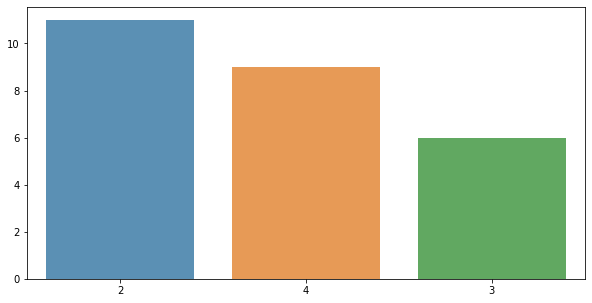

In [30]:
Period_Count =\
df.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [31]:
df9 = df[df['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.mkt_amt.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_out.set_index('name', inplace=True)
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=        shares  ..., width=900)

In [32]:
short_term = (df.period == '4')
df.loc[short_term].head().style.format(format_dict)

,name,shares,unit_cost,dividend,mkt_price,period,cost_amt,mkt_amt,div_amt,cost_pct,mkt_pct,pft_pct,div_rnk,amt_rnk
21,AH,"1,200",฿37.00,฿nan,฿34.00,4,"฿44,400.00","฿40,800.00",฿nan,nan%,nan%,-8.11%,nan,28.0
22,AWC,"9,000",฿4.96,฿nan,฿4.62,4,"฿44,640.00","฿41,580.00",฿nan,nan%,nan%,-6.85%,nan,27.0
23,BCH,"15,000",฿21.46,฿0.8000,฿17.50,4,"฿321,900.00","฿262,500.00","฿12,000.00",3.73%,4.57%,-18.45%,18.0,12.0
24,ICHI,"1,500",฿14.30,฿nan,฿13.80,4,"฿21,450.00","฿20,700.00",฿nan,nan%,nan%,-3.50%,nan,30.0
25,JMART,"10,800",฿27.00,฿1.0600,฿16.40,4,"฿291,600.00","฿177,120.00","฿11,448.00",3.93%,6.46%,-39.26%,13.0,18.0


In [33]:
data = df.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'AH', 'AWC', 'BCH', 'ICHI', 'JMART', 'KCE', 'PTG', 'SINGER', 'SYNEX'"

In [34]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('AH', 'AWC', 'BCH', 'ICHI', 'JMART', 'KCE', 'PTG', 'SINGER', 'SYNEX')


,min,price,max
name,,,
AH,19.40,32.50,35.75
AWC,4.56,6.05,6.55
BCH,16.80,21.10,23.10
ICHI,7.20,12.10,12.40
JMART,35.25,37.00,64.00
KCE,39.75,50.00,75.50
PTG,12.90,13.30,16.40
SINGER,26.25,27.50,59.25
SYNEX,14.50,16.20,31.00


In [35]:
#stocks.drop('SCC',inplace=True)
#stocks

<AxesSubplot:xlabel='name'>

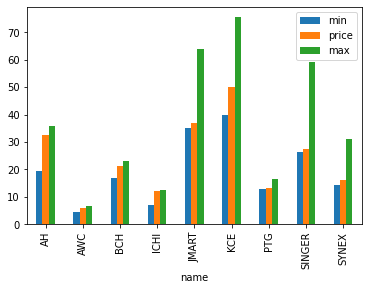

In [36]:
stocks.plot.bar()

In [37]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)

### Portfolio cumulative sum by period, name

In [38]:
colw = 'period name shares unit_cost cost_amt mkt_amt cumsum'.split()
df['cumsum'] = df.groupby('period')['mkt_amt'].cumsum()
df[colw].sort_values(by=['period','name'],ascending=[True,True]).style.format(format_dict)

,period,name,shares,unit_cost,cost_amt,mkt_amt,cumsum
0,1,MCS,"78,000",฿15.10,"฿1,177,800.00","฿495,300.00","฿495,300.00"
1,1,PTTGC,"6,000",฿64.75,"฿388,500.00","฿243,000.00","฿738,300.00"
2,1,SENA,"105,000",฿4.48,"฿470,400.00","฿315,000.00","฿1,053,300.00"
3,1,TMT,"36,000",฿10.20,"฿367,200.00","฿262,800.00","฿1,316,100.00"
4,2,ASP,"30,000",฿3.80,"฿114,000.00","฿83,400.00","฿83,400.00"
5,2,CPNREIT,"60,000",฿17.55,"฿1,053,000.00","฿654,000.00","฿737,400.00"
6,2,DIF,"30,000",฿14.70,"฿441,000.00","฿321,000.00","฿1,058,400.00"
7,2,GVREIT,"30,000",฿8.90,"฿267,000.00","฿252,000.00","฿1,310,400.00"
8,2,JASIF,"130,000",฿10.00,"฿1,300,000.00","฿903,500.00","฿2,213,900.00"
9,2,NER,"27,000",฿7.45,"฿201,150.00","฿123,120.00","฿2,337,020.00"


In [39]:
df.stb.freq(["period"], value="mkt_amt").style.format(format_dict)

,period,mkt_amt,percent,cumulative_mkt_amt,cumulative_percent
0,2,"฿3,824,920.00",50.01%,"฿3,824,920.00",50.01%
1,1,"฿1,316,100.00",17.21%,"฿5,141,020.00",67.22%
2,3,"฿1,308,425.00",17.11%,"฿6,449,445.00",84.33%
3,4,"฿1,198,520.00",15.67%,"฿7,647,965.00",100.00%
